Can we develop a model that accurately predicts turbidity for one day in the future using historical data?

# SARIMA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Reads the CSV file we got after pre-processing into a Pandas dataframe with two columns(data and turbidity), applies data type conversion and replaces missing and zero values with the mean value of the "turbidity" column. The "Date" column is converted to a datetime format and used as the index of the resulting Pandas dataframe.

In [ ]:
df = pd.read_csv("data.csv", usecols=['Date', 'turbidity'])

df["turbidity"] = pd.to_numeric(df["turbidity"], errors='coerce')

val = df['turbidity'].mean(skipna=True)

df["turbidity"] = df["turbidity"].replace(0, val)
df.fillna(val, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [ ]:
df.isnull().any()

turbidity    False
dtype: bool

In [ ]:
df = df.squeeze(axis=0)
display(df)

,turbidity
Date,
2019-01-01,0.442644
2019-01-02,0.401000
2019-01-03,0.374000
2019-01-04,0.361000
2019-01-05,0.351000
...,...
2022-12-27,0.314000
2022-12-28,0.564500
2022-12-29,0.434000


Splitting training and testing set

In [ ]:
train = df[:1400]
test = df[-61:]
print(train)
print(test)

            turbidity
Date                 
2019-01-01   0.442644
2019-01-02   0.401000
2019-01-03   0.374000
2019-01-04   0.361000
2019-01-05   0.351000
...               ...
2022-10-27   0.717000
2022-10-28   0.787000
2022-10-29   0.613000
2022-10-30   0.442644
2022-10-31   0.685000

[1400 rows x 1 columns]
            turbidity
Date                 
2022-11-01     0.9370
2022-11-02     0.6830
2022-11-03     0.6670
2022-11-04     0.7470
2022-11-05     0.6470
...               ...
2022-12-27     0.3140
2022-12-28     0.5645
2022-12-29     0.4340
2022-12-30     0.3770
2022-12-31     0.3430

[61 rows x 1 columns]


Performing the Augmented Dickey-Fuller test on a time series of turbidity values. The test is used to determine whether the time series is stationary or not.

In [ ]:
from statsmodels.tsa.stattools import adfuller
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(train['turbidity'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -5.915831e+00
p-value                        2.574268e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.386000e+03
Critical Value (1%)           -3.435077e+00
Critical Value (5%)           -2.863628e+00
Critical Value (10%)          -2.567881e+00
dtype: float64


In [ ]:
!pip install pmdarima --quiet
import pmdarima as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.5 MB/s eta 0:00:00


Fitting a Seasonal AutoRegressive Integrated Moving Average (SARIMA) model to the time series of turbidity values stored in the train variable. The pm.auto_arima function is being used to determine the optimal values of the model's parameters, such as the order of differencing and the number of autoregressive and moving average terms. The model is being set to seasonal mode by setting the seasonal parameter to True and specifying the frequency of the cycle as 12. The stepwise parameter is set to True to perform a stepwise search for the best set of parameters. The fitted SARIMA model can be used to make predictions and analyze the behavior of the time series.

In [ ]:

# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(train["turbidity"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Visualizing the diagnostic plots of the model. 

- The top left plot is a histogram of the residuals, which should ideally follow a normal distribution.
- The top right plot is a kernel density estimate of the residuals, which should be close to a normal distribution.
- The bottom left plot is a Q-Q plot of the residuals, which should ideally follow a straight line.
- The bottom right plot is a plot of the autocorrelation function (ACF) of the residuals, which should ideally be close to zero for all lags.

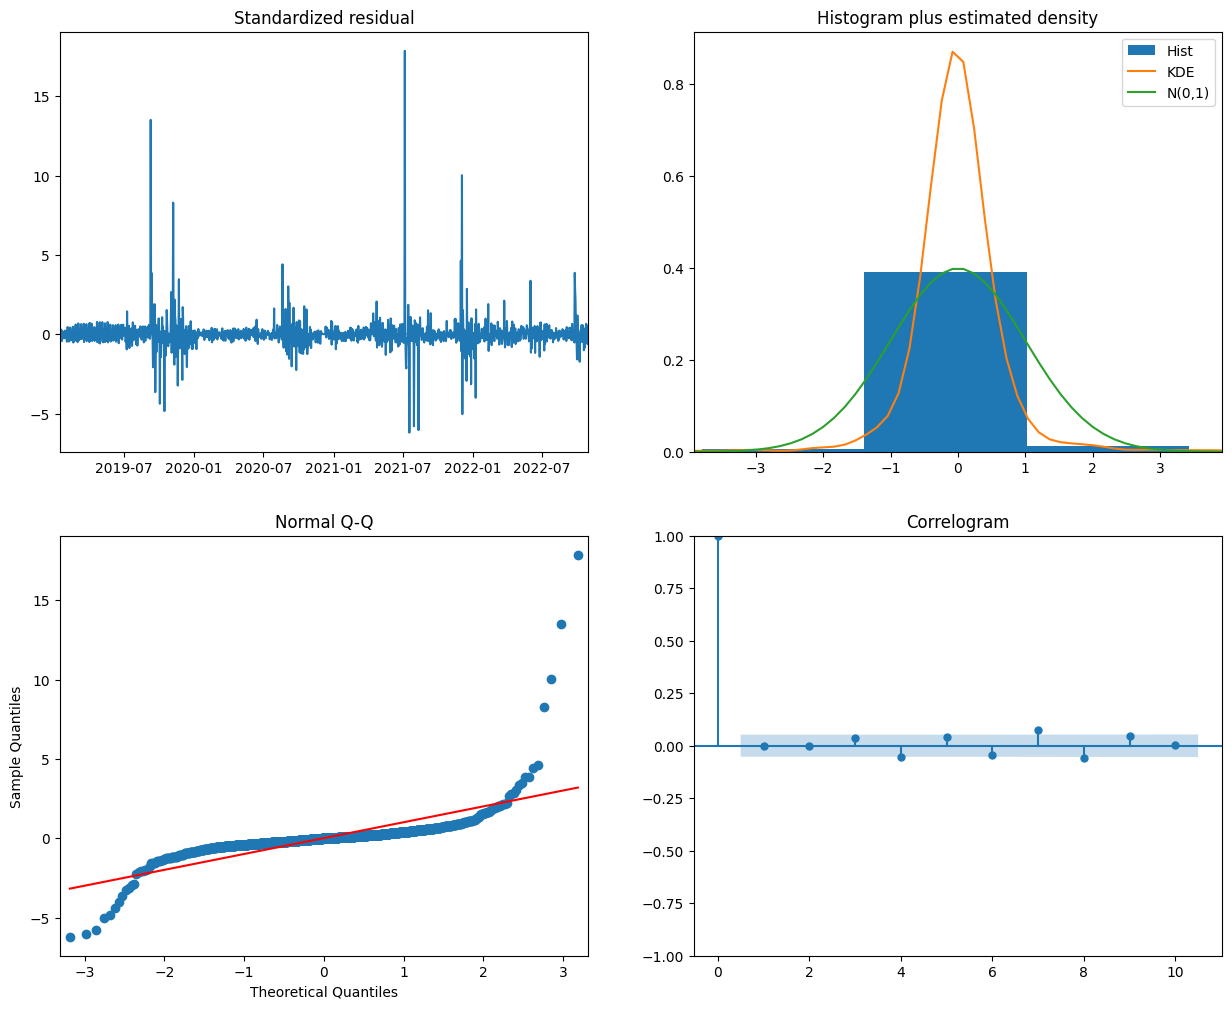

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

The forecast function is used to make predictions with the fitted SARIMA model. The predict method of the model is used to obtain the predicted values and confidence intervals for the specified number of periods. The resulting predicted values are plotted against the actual values of the test set, and the root mean squared error (RMSE), standard deviation, and R-squared values are printed out for evaluation. The function also plots the forecasted values along with the training data and the confidence intervals. This visualization can be used to analyze the performance of the model and to identify any areas where the model may need to be improved.

RMSE: 0.25375460564797875
Standard Daviation: 0.19147477979687988
R2 Score: -0.7855963686011382


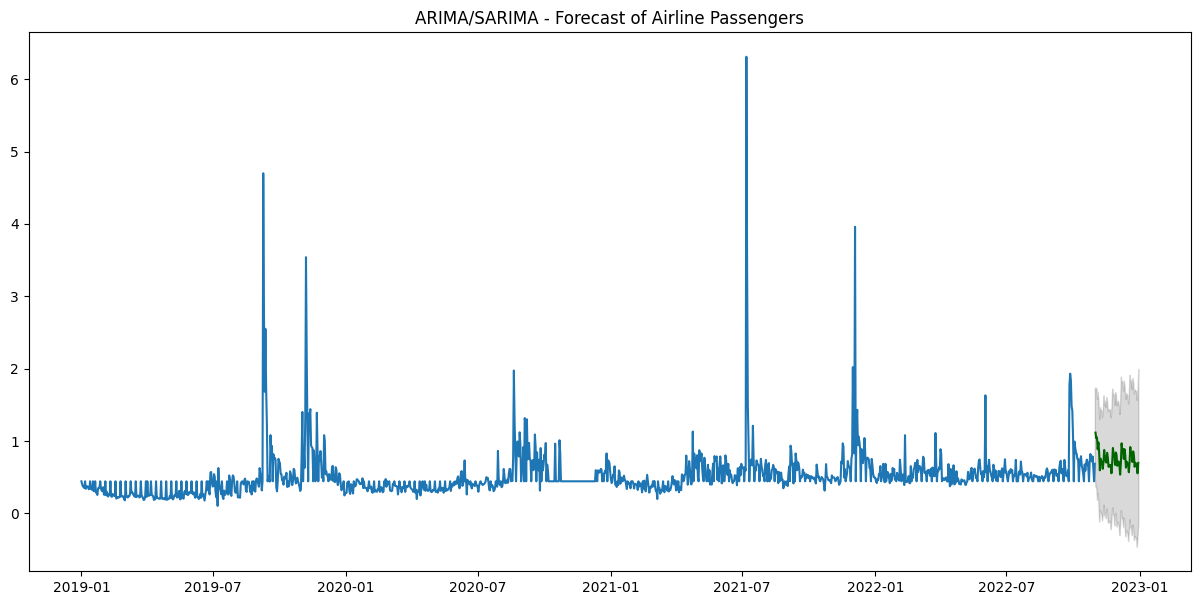

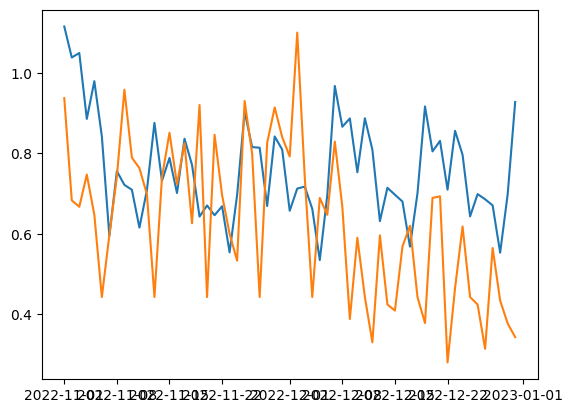

In [ ]:
from sklearn.metrics import r2_score

# print(len(test))
def rmse(values, predictions, skip=0):
    import math
    assert(len(values) == len(predictions))
    return math.sqrt(sum([(values[i]-predictions[i])**2 for i in range(skip, len(values))])/len(values))


def forecast(ARIMA_model, periods=61):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    #RSME
    print(f"RMSE: {rmse(test.iloc[:,0],fitted)}")
    print(f"Standard Daviation: {test['turbidity'].std() }")
    print(f"R2 Score: {r2_score(test.iloc[:,0],fitted)}")
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(train["turbidity"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()
    plt.plot(fitted)
    plt.plot(test)
    plt.show()

forecast(SARIMA_model)

# Prophet

In [ ]:
!pip install prophet --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

Reads the data.csv file, renames the "Date" and "turbidity" columns to input 'ds' and 'y' for Prophet, and then plots the "turbidity" values against the "Date" values using matplotlib. The "turbidity" column is also checked for data type and missing values, which are replaced with the mean value of the column.

ds     object
y     float64
dtype: object

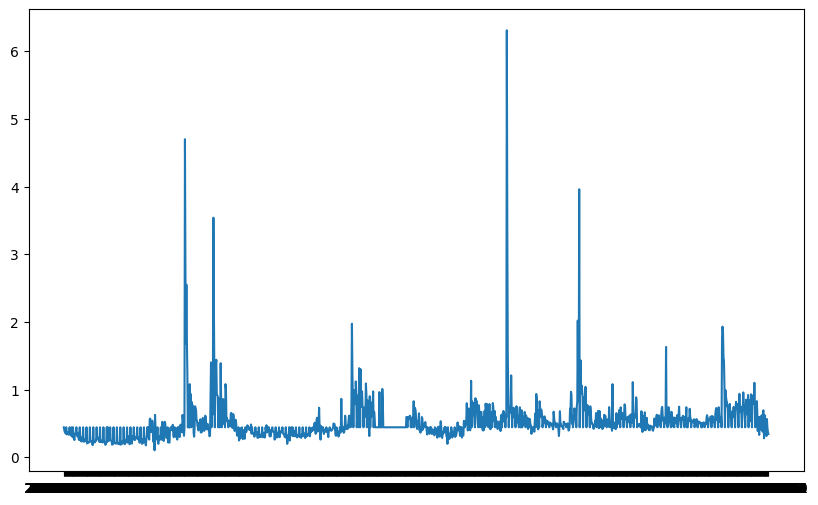

In [2]:
data = pd.read_csv("data.csv", usecols=['Date', 'turbidity'])
df = data.rename(columns={'Date': 'ds', 'turbidity': 'y'})
# cleaning data
df["y"] = pd.to_numeric(df["y"], errors='coerce')
val = df['y'].mean(skipna=True)
df["y"] = df["y"].replace(0, val)
df.fillna(val, inplace=True)
df.reset_index()
#plotting original data
fig = plt.figure(facecolor='w', figsize=(10, 6))
plt.plot(df.ds, df.y)
df.dtypes

In [3]:
#spilliting data into training and test
train = df[:1400]
test = df[-61:]
print(train)
print(test)

              ds         y
0     2019-01-01  0.442644
1     2019-01-02  0.401000
2     2019-01-03  0.374000
3     2019-01-04  0.361000
4     2019-01-05  0.351000
...          ...       ...
1395  2022-10-27  0.717000
1396  2022-10-28  0.787000
1397  2022-10-29  0.613000
1398  2022-10-30  0.442644
1399  2022-10-31  0.685000

[1400 rows x 2 columns]
              ds       y
1400  2022-11-01  0.9370
1401  2022-11-02  0.6830
1402  2022-11-03  0.6670
1403  2022-11-04  0.7470
1404  2022-11-05  0.6470
...          ...     ...
1456  2022-12-27  0.3140
1457  2022-12-28  0.5645
1458  2022-12-29  0.4340
1459  2022-12-30  0.3770
1460  2022-12-31  0.3430

[61 rows x 2 columns]


Initializes a Prophet model with yearly seasonality and fits the model to the input dataframe df using the fit() method.

In [15]:
#training model
m = Prophet(yearly_seasonality=True)
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq8jjbr4_/i1fvmx7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq8jjbr4_/x14et6m4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41601', 'data', 'file=/tmp/tmpq8jjbr4_/i1fvmx7k.json', 'init=/tmp/tmpq8jjbr4_/x14et6m4.json', 'output', 'file=/tmp/tmpq8jjbr4_/prophet_modelzylr9kz2/prophet_model-20230412134712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:47:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
#predicting on test
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
56,2022-12-27,0.592414,0.223090,0.947416
57,2022-12-28,0.611177,0.211248,1.029613
58,2022-12-29,0.595411,0.209070,0.950894
59,2022-12-30,0.574495,0.174351,0.952448
60,2022-12-31,0.563648,0.163705,0.954878


In [17]:
#calculating RMSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
y_actual = test.loc[:,"y"]
y_predicted = forecast.loc[:,"yhat"]
 
MSE = mean_squared_error(y_actual, y_predicted)
 
RMSE = math.sqrt(MSE)
R2 = r2_score(y_actual, y_predicted)
print(RMSE)
print(R2)

0.1820059948723974
0.08139921339263412


In [7]:
#standard deviation
y_actual.std()

0.19147477979687988

In [8]:
#training on df for futute prediction
m1 = Prophet()
m1.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq8jjbr4_/xpuxj60n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq8jjbr4_/bdd1d4xg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14983', 'data', 'file=/tmp/tmpq8jjbr4_/xpuxj60n.json', 'init=/tmp/tmpq8jjbr4_/bdd1d4xg.json', 'output', 'file=/tmp/tmpq8jjbr4_/prophet_modelecv_42bp/prophet_model-20230412132941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:29:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:29:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Creates a future dataframe with 365 days in the future and generates a forecast using the fitted Prophet model m. The resulting forecast dataframe contains the predicted values for the ds column, as well as the yhat, yhat_lower, and yhat_upper columns which represent the predicted values and associated uncertainty intervals. 

In [9]:
#Creating a future df
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1760,2023-10-27
1761,2023-10-28
1762,2023-10-29
1763,2023-10-30
1764,2023-10-31


In [10]:
#predicting on future
forecast = m1.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1760,2023-10-27,0.563247,0.195741,0.945671
1761,2023-10-28,0.568103,0.180332,0.945414
1762,2023-10-29,0.497611,0.103916,0.878662
1763,2023-10-30,0.590748,0.190123,0.960228
1764,2023-10-31,0.597399,0.232493,1.006683


Plotting the results

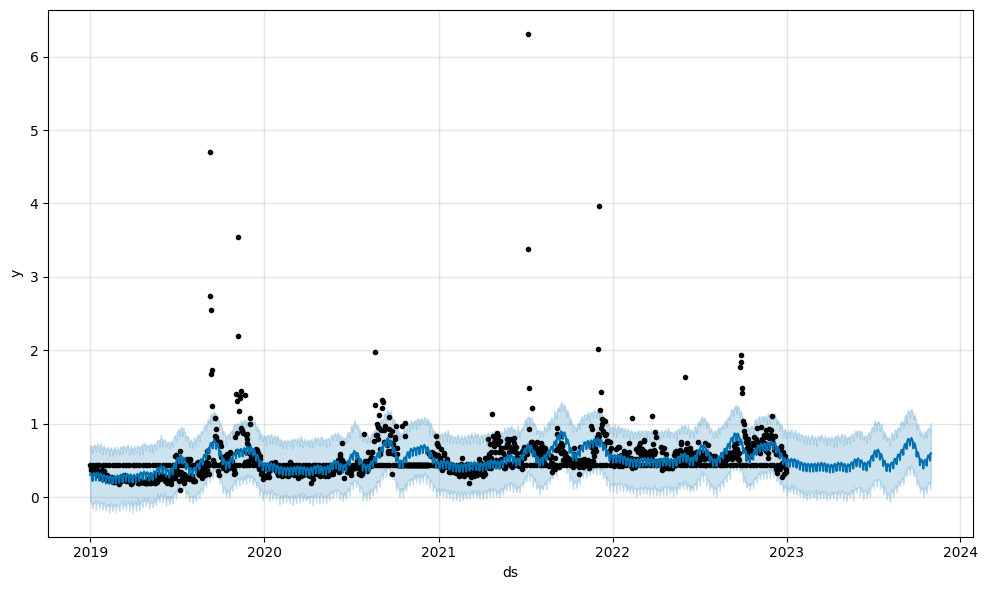

In [11]:
#plotting all df and future
fig1 = m1.plot(forecast)